## Preliminaries

### Install

In [0]:
#!pip install numpy scipy pandas matplotlib scikit-learn Cython
!pip install qutip

    100% |████████████████████████████████| 5.5MB 5.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/f1/a4/f5687d0ab63c65cd818a29e7826f6ad677887730290476aabc
Successfully built qutip


### creating workspace

In [0]:
import ipywidgets as widgets # Loads the Widget framework.
from IPython.core.magics.namespace import NamespaceMagics # Used to query namespace.

# For this example, hide these names, just to avoid polluting the namespace further
get_ipython().user_ns_hidden['widgets'] = widgets
get_ipython().user_ns_hidden['NamespaceMagics'] = NamespaceMagics

In [0]:
class VariableInspectorWindow(object):
    instance = None
    
    def __init__(self, ipython):
        """Public constructor."""
        if VariableInspectorWindow.instance is not None:
            raise Exception("""Only one instance of the Variable Inspector can exist at a 
                time.  Call close() on the active instance before creating a new instance.
                If you have lost the handle to the active instance, you can re-obtain it
                via `VariableInspectorWindow.instance`.""")
        
        VariableInspectorWindow.instance = self
        self.closed = False
        self.namespace = NamespaceMagics()
        self.namespace.shell = ipython.kernel.shell
        
        self._box = widgets.Box()
        self._box.layout.overflow_y = 'scroll'
        self._table = widgets.HTML(value = 'Not hooked')
        self._box.children = [self._table]
        
        self._ipython = ipython
        self._ipython.events.register('post_run_cell', self._fill)
        
    def close(self):
        """Close and remove hooks."""
        if not self.closed:
            self._ipython.events.unregister('post_run_cell', self._fill)
            self._box.close()
            self.closed = True
            VariableInspectorWindow.instance = None

    def _fill(self):
        """Fill self with variable information."""
        values = self.namespace.who_ls()
        self._table.value = '<div class="rendered_html jp-RenderedHTMLCommon"><table><thead><tr><th>Name</th><th>Type</th><th>Value</th></tr></thead><tr><td>' + \
            '</td></tr><tr><td>'.join(['{0}</td><td>{1}</td><td>{2}'.format(v, type(eval(v)).__name__, str(eval(v))) for v in values]) + \
            '</td></tr></table></div>'

    def _ipython_display_(self):
        """Called when display() or pyout is used to display the Variable 
        Inspector."""
        self._box._ipython_display_()

### imports

In [0]:
import time
import warnings
import pickle
import io, requests, zipfile

In [0]:
import numpy as np
from numba import jit, prange
import pandas as pd
import matplotlib.pyplot as plt
import qutip as Q

In [0]:
from scipy.optimize import minimize
## distribution for randomCV

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler # scale
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.model_selection import train_test_split ,  cross_val_score , cross_validate ,GridSearchCV , RandomizedSearchCV 
from sklearn.model_selection import validation_curve , learning_curve

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [0]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

### plot options

In [0]:
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )

plt.rc('lines', markersize = 5 )

plt.rc('figure', figsize=(20,8) )         # Image size

## Workspace

In [0]:
inspector = VariableInspectorWindow(get_ipython())
inspector
#inspector.close()

Box(children=(HTML(value='Not hooked'),), layout=Layout(overflow_y='scroll'))

## Data (x,y,yc)

### data construction via qutip

In [0]:
%%time
#O(n) , 10000 = 40s
N = 50000

sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
f = np.empty((4,4))
x = np.empty((N,15))
y = np.empty(N)
yc = np.empty(N,dtype=np.int64)

for k in range(N):
  rho1 = Q.rand_dm(4,dims=[ [2,2] , [2,2] ] )
  
  
  for i in range(4):
    for j in range(4):
      f[i,j] = (rho1* Q.tensor(sigma[i],sigma[j])).tr().real

  x[k] = np.delete(f.reshape(1,16),15)
  rho2 = Q.partial_transpose(rho1, [0,1] )
  #rhot = rho1.full().reshape((2,2,2,2)).transpose((0,3,2,1)).reshape(4,4)
  #print (np.abs(rho2.full() - rhot).sum())
  y[k] = np.linalg.det(rho2.full()).real
  if y[k] < 0 :
    yc[k]=1 #Entangled
  else:
    yc[k]=0 #Separable
y=y.reshape(N,1)

CPU times: user 3min 24s, sys: 94.4 ms, total: 3min 24s
Wall time: 3min 24s


### Other methods for data construction

#### qutip data analysis

In [0]:
%%time
b=Q.Bloch()
b.point_color=['b']
b.point_marker=['o']
b.point_size=[20]

N=10000
sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
f=np.empty((N,3))
g=np.empty((N,3))
a=np.empty((N,4))

for i in range(N):
  rho = Q.rand_dm(4,dims=[ [2,2] , [2,2] ] )
  
  rhoA = rho.ptrace(0)
  
  #rhoA = Q.rand_dm(2)
  
  a[i,0] = rhoA.full()[0,0]
  a[i,1] = rhoA.full()[0,1]
  a[i,2] = rhoA.full()[1,0]
  a[i,3] = rhoA.full()[1,1]
  
  b.add_states(rhoA,kind='point')
  
  for k in range(3):
    f[i,k] = ( sigma[k] * rhoA ).tr().real
  g[i,0]= (f[i,:].dot(f[i,:]) )
  g[i,1]=np.arccos(f[i,2]/g[i,0])
  g[i,2]=np.arctan(f[i,1]/f[i,0])
 
 
b.show()

fig = plt.figure()
ax=[]
ti=['x','y','z']
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1,title=ti[i]) )
  ax[i].hist(f[:,i],bins=50)

plt.show()
#plt.tight_layout()
plt.close()



fig = plt.figure()
ax=[]
ti=['r','theta','phi']
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1,title=ti[i]) )
  ax[i].hist(g[:,i],bins=80)

plt.show()
#plt.tight_layout()
plt.close()

#fig = plt.figure()
#ax=[]
#ti=['rho11', 'rho12', 'rho21', 'rho22']
#for i in range(4) :
#  ax.append( fig.add_subplot(4,4,i+1,title=ti[i]) )
#  ax[i].hist(a[:,i],bins=50)

#plt.show()
#plt.tight_layout()
#plt.close()


#### numpy (still error with numba)

In [0]:
%%time

#@jit(nopython=True)
def rho_gen():
  rho = np.random.rand(4,4) + 1j*np.random.rand(4,4)
  rho = rho.dot( np.conjugate(rho).T )
  return 1/np.trace(rho)*rho
    
def sth(N):

  for k in range(N):
    rho = rho_gen()
    m=0
    for i in range(4):
      for j in range(4):
        if m==15: break
        x[k,m] = np.trace ( rho.dot(  np.kron(sigma[i],sigma[j])  ) ).real
        m+=1

    
    rhot = rho.reshape((2,2,2,2)).transpose((0,3,2,1)).reshape(4,4)
    
    print('rhott')
    print(rhott.shape)
    
    print(X1.strides)
    rhottt = np.reshape(X1, (4,4) ) ##here is the problem can not convert (2,2,2,2) to (4,4)
    rhof = rho
    y[k] = np.linalg.det(rhof).real
    if y[k] < 0 :
      yc[k]=1 #Entangled
    else:
      yc[k]=0 #Separable
  return x , yc , y.reshape(N,1)
  
x , yc , y = sth(10)

NameError: ignored

#### construcing via unif on x, then y , then z

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


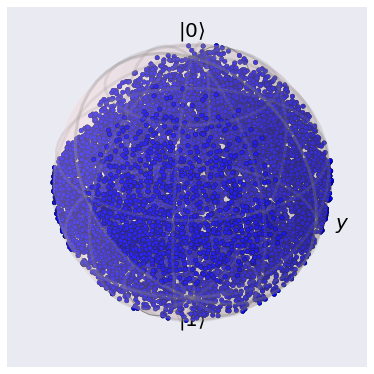

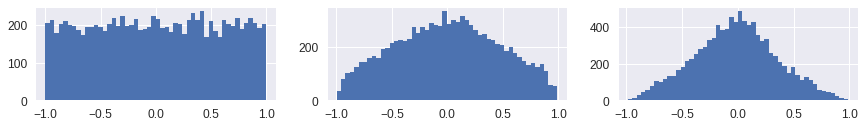

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


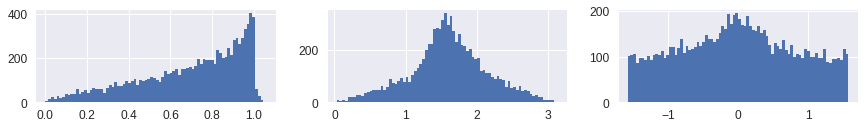

In [0]:
b=Q.Bloch()
b.point_color=['b']
b.point_marker=['o']
b.point_size=[20]

N=10000
sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
f=np.empty((N,3))
g=np.empty((N,3))

f[:,0] = np.random.uniform(-1,1,(N))


for i in range(N):
  f[i,1] = np.random.uniform(-np.sqrt(1-f[i,0]**2),np.sqrt(1-f[i,0]**2))
  f[i,2] = np.random.uniform(-np.sqrt(1-f[i,0]**2-f[i,1]**2),np.sqrt(1-f[i,0]**2)-f[i,1]**2)
  
  rhoA = 1./2 *(sigma[3] + f[i,0]*sigma[0] + f[i,1]*sigma[1] + f[i,2]*sigma[2])
  
  
  g[i,0]= np.sqrt(f[i,:].dot(f[i,:]) )
  g[i,1]=np.arccos(f[i,2]/g[i,0])
  g[i,2]=np.arctan(f[i,1]/f[i,0])
  b.add_states(rhoA,kind='point')
 
b.show()

fig = plt.figure()

ax=[]
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1) )
  ax[i].hist(f[:,i],bins=50)


plt.show()
#plt.tight_layout()
plt.close()



fig = plt.figure()

ax=[]
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1) )
  ax[i].hist(g[:,i],bins=80)


plt.show()
#plt.tight_layout()
plt.close()

#### constructing via uniform on phi, theta

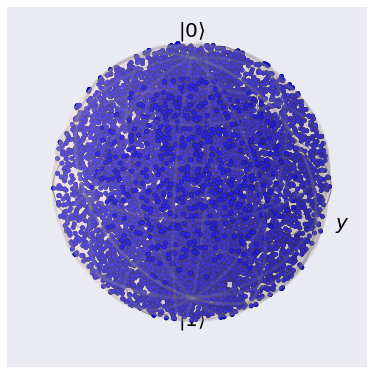

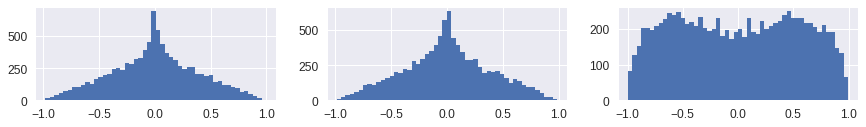

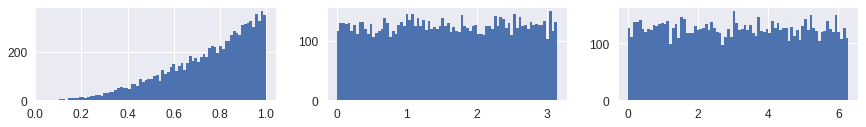

In [0]:
b=Q.Bloch()
b.point_color=['b']
b.point_marker=['o']
b.point_size=[20]

N=10000
sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
f=np.empty((N,3))
g=np.empty((N,3))

f[:,0] = np.random.uniform(-1,1,N)

g[:,0] = np.random.power(3,N)
g[:,1] = np.random.uniform(0,np.pi,N)
g[:,2] = np.random.uniform(0,2*np.pi,N)


f[:,0] = g[:,0]*np.sin(g[:,1])*np.cos(g[:,2])
f[:,1] = g[:,0]*np.sin(g[:,1])*np.sin(g[:,2])
f[:,2] = g[:,0]*np.cos(g[:,1])


for i in range(N):
  
  rhoA = 1./2 *(sigma[3] + f[i,0]*sigma[0] + f[i,1]*sigma[1] + f[i,2]*sigma[2])
  b.add_states(rhoA,kind='point')
 
b.show()

fig = plt.figure()

ax=[]
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1) )
  ax[i].hist(f[:,i],bins=50)


plt.show()
#plt.tight_layout()
plt.close()



fig = plt.figure()

ax=[]
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1) )
  ax[i].hist(g[:,i],bins=80)


plt.show()
#plt.tight_layout()
plt.close()

In [0]:
a=np.arange(1)

#### the REAL uniform: according to wolfram alpha

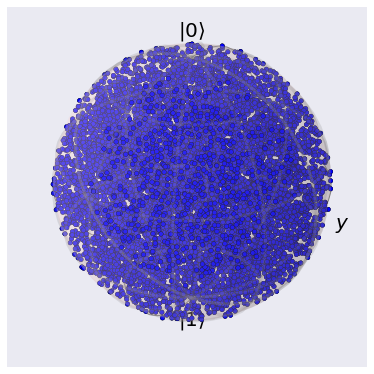

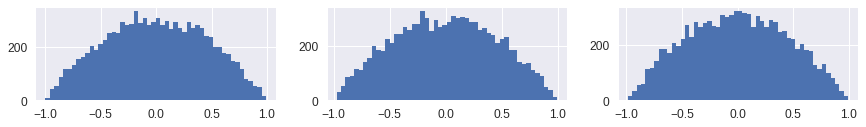

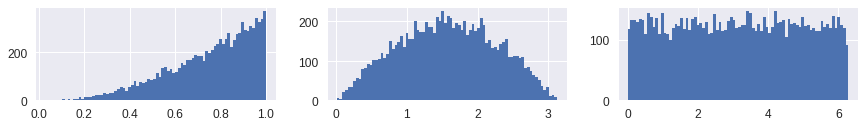

In [0]:
b=Q.Bloch()
b.point_color=['b']
b.point_marker=['o']
b.point_size=[20]

N=10000
sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
f=np.empty((N,3))
g=np.empty((N,3))
u=np.empty(N)
f[:,0] = np.random.uniform(-1,1,N)


u=np.random.uniform(0,1,N)



g[:,0] = np.random.power(3,N)
g[:,1] = np.arccos(2*u-1) #wow
g[:,2] = np.random.uniform(0,2*np.pi,N)


f[:,0] = g[:,0]*np.sin(g[:,1])*np.cos(g[:,2])
f[:,1] = g[:,0]*np.sin(g[:,1])*np.sin(g[:,2])
f[:,2] = g[:,0]*np.cos(g[:,1])


for i in range(N):
  
  rhoA = 1./2 *(sigma[3] + f[i,0]*sigma[0] + f[i,1]*sigma[1] + f[i,2]*sigma[2])
  b.add_states(rhoA,kind='point')
 
b.show()

fig = plt.figure()

ax=[]
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1) )
  ax[i].hist(f[:,i],bins=50)


plt.show()
#plt.tight_layout()
plt.close()



fig = plt.figure()

ax=[]
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1) )
  ax[i].hist(g[:,i],bins=80)


plt.show()
#plt.tight_layout()
plt.close()

#### Another method for real uniform

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


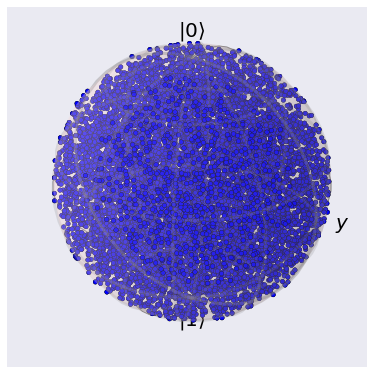

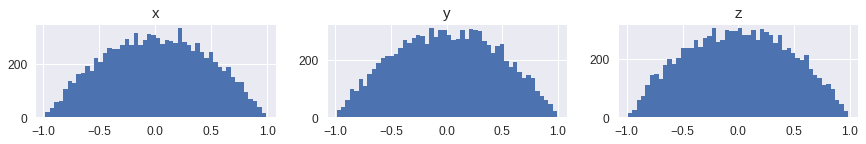

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


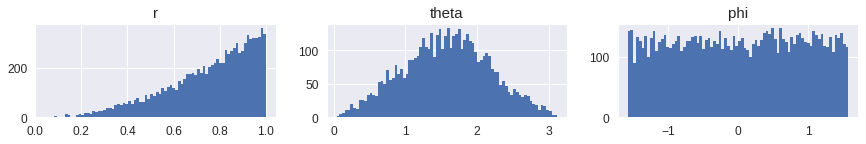

In [0]:
bloch=Q.Bloch()
bloch.point_color=['b']
bloch.point_marker=['o']
bloch.point_size=[20]

N=10000

sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
f=np.empty((N,3))
polar=np.empty((N,3))
g=np.empty((N,3))
r=np.empty(N)

g[:,0] = np.random.randn(N)
g[:,1] = np.random.randn(N)
g[:,2] = np.random.randn(N)
r = np.random.power(3,N)

for i in range(3): f[:,i] = r * 1/np.sqrt(g[:,0]*g[:,0]+g[:,1]*g[:,1]+g[:,2]*g[:,2]) * g[:,i] 

polar[:,0]= np.sqrt(f[:,0]*f[:,0] + f[:,1]*f[:,1] +f[:,2]*f[:,2] )
polar[:,1]=np.arccos(f[:,2]/f[:,0])
polar[:,2]=np.arctan(f[:,1]/f[:,0])

  
for i in range(N):
  rhoA = 1./2 *(sigma[3] + f[i,0]*sigma[0] + f[i,1]*sigma[1] + f[i,2]*sigma[2])
  bloch.add_states(rhoA,kind='point')
  
bloch.show()

fig = plt.figure()
ax=[]
ti=['x','y','z']
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1,title=ti[i]) )
  ax[i].hist(f[:,i],bins=50)

plt.show()
plt.close()


fig = plt.figure()
ax=[]
ti=['r','theta','phi']
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1,title=ti[i]) )
  ax[i].hist(polar[:,i],bins=80)

plt.show()
plt.close()

#### numpy data analysis

In [0]:
b=Q.Bloch()
b.point_color=['b']
b.point_marker=['o']
b.point_size=[20]

N=10000
sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
f=np.empty((N,3))
g=np.empty((N,3))

for i in range(N):
  rho = Q.rand_dm(4,dims=[ [2,2] , [2,2] ] )
  
  rhoA = rho.ptrace(0)
  
  for k in range(3):
    f[i,k] = ( sigma[k] * rhoA ).tr().real
  g[i,0]= (f[i,:].dot(f[i,:]) )
  g[i,1]=np.arccos(f[i,2]/g[i,0])
  g[i,2]=np.arctan(f[i,1]/f[i,0])
  b.add_states(rhoA,kind='point')
 
b.show()

fig = plt.figure()

ax=[]
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1) )
  ax[i].hist(f[:,i],bins=50)


plt.show()
#plt.tight_layout()
plt.close()



fig = plt.figure()

ax=[]
for i in range(3) :
  ax.append( fig.add_subplot(4,4,i+1) )
  ax[i].hist(g[:,i],bins=80)


plt.show()
#plt.tight_layout()
plt.close()

### data check, save/load

In [0]:
###data check
print('x.shape : '+str(x.shape))
print('y.shape : '+str(y.shape))
print('yc.shape : '+str(yc.shape))
#print(y[:2])
#print(x[:3])

x.shape : (50000, 15)
y.shape : (50000, 1)
yc.shape : (50000,)


In [0]:
np.save('X',x)
np.save('Y',y)
np.save('YC',yc)

In [0]:
x=np.load('X.npy')
y=np.load('Y.npy')
yc=np.load('YC.npy')

### data histogram and analysis

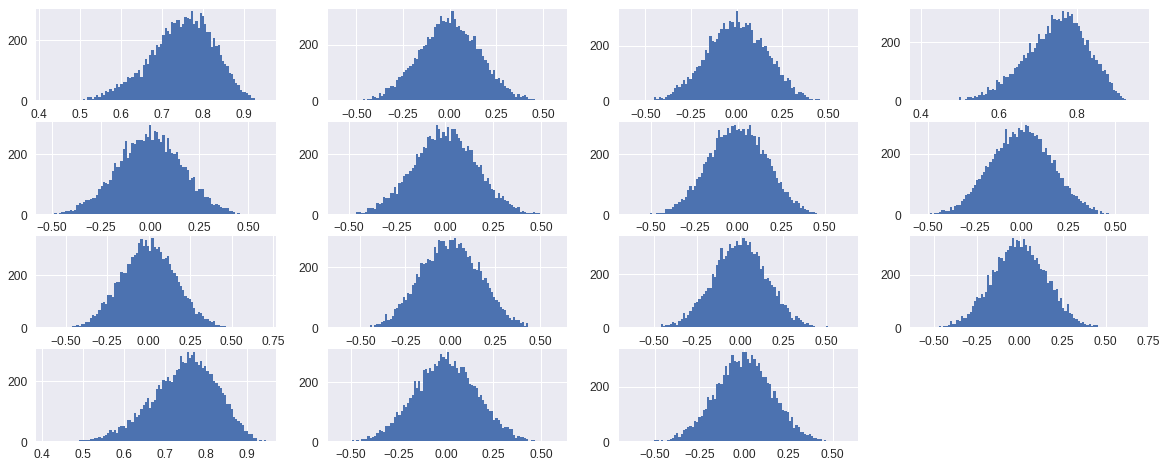

In [0]:
fig = plt.figure()

ax=[]
for i in range(15) :
  ax.append( fig.add_subplot(4,4,i+1) )
  ax[i].hist(x[:,i],bins=100)

plt.show()
#plt.tight_layout()
plt.close()

#Learning

### data prepration ( x_poly_scale_learnsub ,  y_scale_learnsub,  yc_learnsub)

#### feature reduction

In [0]:
xo=np.delete(x,4,axis=1)

#### polyfeature

In [0]:
polyt = PolynomialFeatures(degree=4)
x_p = polyt.fit_transform(xo)

#### scale

In [0]:
scaler_s = StandardScaler() #fit_transform, transform, fit
scaler_r = RobustScaler()
scaler_m = MinMaxScaler()


x_s = scaler_s.fit_transform(x)
x_ps = scaler_s.fit_transform(x_p)
#y_s = scaler.fit_transform(y)
y_s = y*1000

#### check

In [0]:
print(xo.shape)
print('x_p.shape : '+str(x_p.shape))
print(y_s[:5])

### subset of data for learning

In [44]:
Nl=50000
x_sl = x_s[:Nl]
x_psl = x_ps[:Nl]
y_sl = y_s[:Nl]
yc_l = yc[:Nl]

xtrain, xtest , ytrain , ytest, yctrain, yctest = train_test_split(x_sl,y_sl,yc_l,train_size=0.75,random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
#check
print('frequency of data : ',str(yc_l.sum()/Nl))
print(ytrain.shape)
print(ytest.shape)
print(yctrain.shape)

## Classification Methods

### SGD (0.85)

In [0]:
from scipy.stats import expon
params_dist = {'C': expon(scale=10), 'gamma':expon(scale=10)}

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
pos_label = 0
# del(pos_label)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision':make_scorer(precision_score, pos_label=pos_label)
           , 'recall':make_scorer(recall_score, pos_label=pos_label), 'f1':make_scorer(f1_score, pos_label=pos_label)}

opt_clf = RandomizedSearchCV(clf, param_distributions=params_dist, cv=5, n_jobs=-1, refit='precision', scoring=scoring)
opt_clf.fit(X_train,Y_train)

In [0]:
%%time
#train , O(n) , 10000 = 0.8s
warnings.filterwarnings('always')

sgd_clf = SGDClassifier(max_iter=10,tol=0.1)

#opt_clf = RandomizedSearchCV(clf, param_distributions=params_dist, cv=5, n_jobs=-1, refit='precision', scoring=scoring)
scores = cross_val_score(sgd_clf, x_ps , yc , cv=5, n_jobs=-1)

print('train score : \n {}'.format(scores) )

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


train score : 
 [0.87422515 0.87142571 0.87922416 0.888      0.878      0.8728
 0.8796     0.87757552 0.87517504 0.88317664]
CPU times: user 2.39 s, sys: 1.5 s, total: 3.89 s
Wall time: 1min


In [38]:
opt_sgd_param = {'max_iter':10 , 'tol':0.1}
#SGDClassifier(**opt_sgd_param)
train_sizes = list(np.linspace(0.1,1,10))


ns_list, train_scores, validation_scores = learning_curve(
                                                  estimator =SGDClassifier() , X = x_ps,
                                                  y = yc, train_sizes =train_sizes, cv = 5,
                                                  n_jobs=-1,verbose=1)

[learning_curve] Training set sizes: [ 3999  7999 11999 15999 19999 23999 27999 31999 35999 39999]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/skl

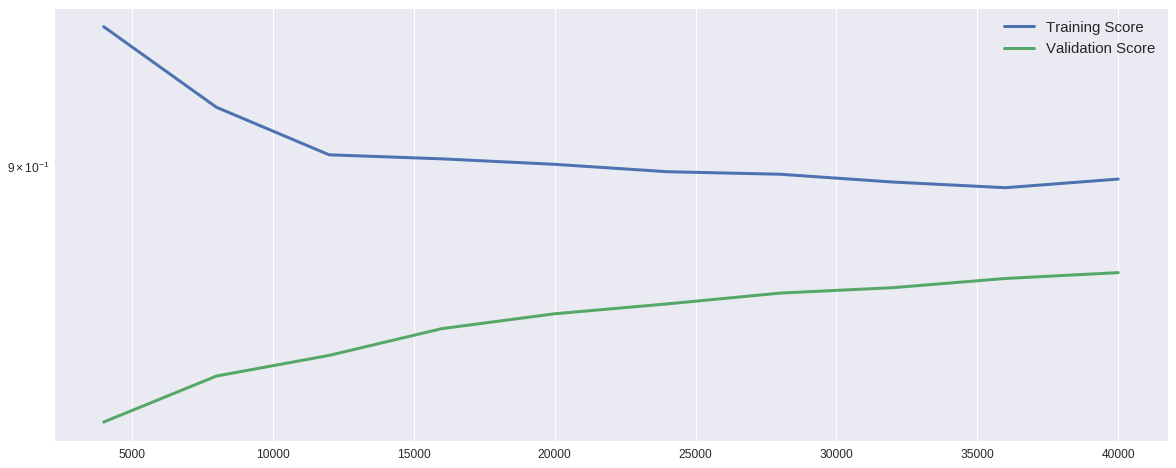

In [39]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ns_list, train_scores_mean, label = 'Training Score')
ax.plot(ns_list, validation_scores_mean, label = 'Validation Score')
ax.legend(loc=0)
plt.yscale('log')

plt.show()

In [0]:
%%time
#test , O(n)
print('test score : ' +str(sgd_clf.score(xtest,yctest)))

test score : 0.8428
CPU times: user 19.4 ms, sys: 2.97 ms, total: 22.3 ms
Wall time: 21.2 ms


In [0]:
# search over parameters
warnings.filterwarnings('ignore')
max_score = 0
tols = [0.1, 0.05, 0.01, 0.005, 0.001]

for i in range(10,30,3):
  print('#############')
  print('itr : '+str(i))  
  for j in tols:
    sgd_clf = SGDClassifier(max_iter=i,tol=j)
    sgd_clf.fit(xtrain,yctrain)
    score = sgd_clf.score(xtest,yctest)
    if score - max_score > 0.005:
      max_score = score
      print('test score : ' +str(score))
      print('tol : '+str(j))
      print('train score : ' +str(sgd_clf.score(xtrain,yctrain)))
      print('###')

### Bayes (0.80)

In [0]:
%%time
#O(n) , 10000 = 1.5 s
nb_clf = GaussianNB()
nb_clf.fit(x_ps,yc)
print('train score : ' +str(nb_clf.score(x_ps,yc)))

train score : 0.77454
CPU times: user 6.74 s, sys: 1.03 s, total: 7.77 s
Wall time: 7.77 s


In [0]:
%%time
# test , O(n)
print('test score : ' +str(nb_clf.score(xtest,yctest)))

### Decision Tree (0.78)

In [0]:
%%time
# O(n^1.5?) 2000 = 7.5 s
warnings.filterwarnings('always')
tree_clf = DecisionTreeClassifier(max_depth=6)
tree_clf.fit(xtrain,yctrain)
print('train score : ' +str(tree_clf.score(xtrain,yctrain)))

train score : 0.7513333333333333
CPU times: user 87.7 ms, sys: 913 µs, total: 88.6 ms
Wall time: 92.9 ms


In [0]:
%%time
#test ,  very fast
print('test score : ' +str(tree_clf.score(xtest,yctest)))
print(tree_clf.feature_importances_)

test score : 0.7364
[0.24275906 0.00930674 0.01380163 0.00411582 0.43172845 0.05596031
 0.01173185 0.00167301 0.         0.00882267 0.14633364 0.03892184
 0.00358983 0.         0.03125514]
CPU times: user 3.21 ms, sys: 75 µs, total: 3.28 ms
Wall time: 3.59 ms


### SVC (0.82)

In [0]:
%%time
#O(n^2) , 1000 = 5s
#but best for a specific N
warnings.filterwarnings('always')
svc_clf = SVC(kernel='linear',gamma='auto',degree=4)
svc_clf.fit(xtrain,yctrain)
print('train score : ' +str(svc_clf.score(xtrain,yctrain)))

In [0]:
%%time
#test , O(n^2)
print('test score : ' +str(svc_clf.score(xtest,yctest)))

### KNN (0.54)

In [0]:
%%time
# O(n) 1000 = 80 ms

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(xtrain,yctrain)

In [0]:
%%time
#O(n_learn * n_test = n^2) , 1000 = 1.5 s
print('test score : ' +str(knn_clf.score(xtest,yctest)))

## Regression Methods

### Imported pickle regression

In [0]:
pickle_in = open("reg_im.pickle","rb")
reg_im = pickle.load(pickle_in)

### Linear Regression (1.0 !)

In [0]:
ns_list = [1000, 2000, 3000, 4000, 5000, 6000]
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator = LinearRegression(), X = x_ps,
                                                   y = y_s, train_sizes = ns_list, cv = 5,
                                                   scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

TP


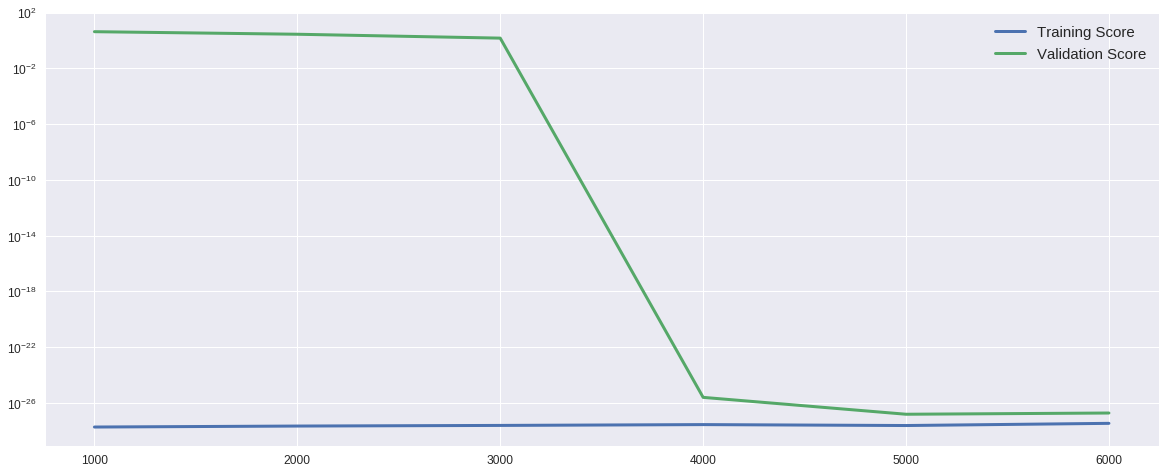

In [0]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ns_list, train_scores_mean, label = 'Training Score')
ax.plot(ns_list, validation_scores_mean, label = 'Validation Score')
plt.yscale('log')
ax.legend(loc=0)
plt.show()

In [45]:
%%time
###train 
# O(n or less) , 5000 = 37s , 10000 = 50s
warnings.filterwarnings('always')
lin_reg = LinearRegression()
lin_reg.fit(xtrain,ytrain)
print('train score : ' +str(lin_reg.score(xtrain,ytrain)))

train score : 0.0004652208656078516
CPU times: user 41.1 ms, sys: 33.1 ms, total: 74.2 ms
Wall time: 99.9 ms


In [0]:
## test
print('test score : ' +str(lin_reg.score(xtest,ytest)))

test score : 0.8923803559370813


In [0]:
## pickle
pickle_out = open("lin_reg.pickle","wb")
pickle.dump(lin_reg, pickle_out)
pickle_out.close()

### Ridge

In [0]:
%%time
#train , 
warnings.filterwarnings('always')
ridge_reg = Ridge()
ridge_reg.fit(xtrain,ytrain)
print('train score : ' +str(ridge_reg.score(xtrain,ytrain)))

In [0]:
print('test score : ' +str(ridge_reg.score(xtest,ytest)))

### Lasso

In [0]:
%%time
#train , 
warnings.filterwarnings('always')
lasso_reg = Lasso()
lasso_reg.fit(xtrain,ytrain)
print('train score : ' +str(lasso_reg.score(xtrain,ytrain)))

In [0]:
print('test score : ' +str(lasso_reg.score(xtest,ytest)))

### SVR

In [0]:
%%time
#train , 
warnings.filterwarnings('always')
svr_reg = SVR(kernel='rbf',gamma='auto')
svr_reg.fit(xtrain,ytrain)
print('train score : ' +str(svr_reg.score(xtrain,ytrain)))

In [0]:
print('test score : ' +str(svr_reg.score(xtest,ytest)))

### Decision Tree

In [0]:
%%time
#train , 
warnings.filterwarnings('always')
tree_reg = DecisionTreeRegressor()
tree_reg.fit(xtrain,ytrain)
print('train score : ' +str(tree_reg.score(xtrain,ytrain)))

train score : 0.999999999931988
CPU times: user 36.4 s, sys: 8.41 ms, total: 36.4 s
Wall time: 36.4 s


In [0]:
print('test score : ' +str(tree_reg.score(xtest,ytest)))

test score : 0.5824895564853767


### KNN

In [0]:
%%time
#train , 
warnings.filterwarnings('always')
knn_reg = KNeighborsRegressor(n_neighbors=3)
knn_reg.fit(xtrain,ytrain)
print('train score : ' +str(knn_reg.score(xtrain,ytrain)))

In [0]:
print('test score : ' +str(knn_reg.score(xtest,ytest)))

## Classifier from linear regression (0.995 - 0.998)

In [0]:
class Qlin_clf:
  
  coef_ = lin_reg.coef_
  
  def predict(self,xtest):
    Nt = xtest.shape[0]
    pre_y = lin_reg.predict(xtest)
    pre_yc = np.empty(Nt,dtype=np.int64)
    for i in range(Nt):
      if pre_y[i,0] <0:
        pre_yc[i] = 1
      else:
        pre_yc[i] = 0
    return pre_yc
  
  def score(self,xtest,ytest):
    Nt = xtest.shape[0]
    pre_yc=self.predict(xtest)
    err = np.abs(yctest-pre_yc)
    return (Nt-err.sum()) /float(Nt)
  
  def wrong_indices(self,xtest,ytest):
    inds =[]
    Nt = xtest.shape[0]
    pre_yc=self.predict(xtest)
    for i in range(Nt):
      if yctest[i] != pre_yc[i]:
        inds.append(i)
    
    return inds

In [0]:
### pickle export
clf_im = Qlin_clf()
pickle_out = open("clf_im.pickle","wb")
pickle.dump(clf_im, pickle_out)
pickle_out.close()

In [0]:
### testing the classifier
clf_im = Qlin_clf()

print('test score : ', str(clf_im.score(xtest,ytest)))

inds=clf_im.wrong_indices(xtest,ytest)

pre_y = lin_reg.predict(xtest)


print('#######################')
print('number of wrong indices: '+str(len(inds)))
for i in inds:
  print('######')
  print('det is : '+str(ytest[i]))
  print('predicted det is : '+str(pre_y[i]))
  

test score :  0.8352
#######################
number of wrong indices: 412
######
det is : [-0.13704286]
predicted det is : [1.01862208]
######
det is : [0.03780813]
predicted det is : [-0.66461496]
######
det is : [0.45066963]
predicted det is : [-0.90803259]
######
det is : [-1.20938101]
predicted det is : [0.21644978]
######
det is : [0.29605211]
predicted det is : [-0.39240087]
######
det is : [0.07467218]
predicted det is : [-0.17327568]
######
det is : [-0.100796]
predicted det is : [1.41874277]
######
det is : [-0.04158932]
predicted det is : [0.11145151]
######
det is : [-0.08384117]
predicted det is : [3.29514727]
######
det is : [-0.0036027]
predicted det is : [0.14573105]
######
det is : [0.8633266]
predicted det is : [-0.13155219]
######
det is : [-0.83898581]
predicted det is : [0.04492689]
######
det is : [-0.1443834]
predicted det is : [0.05719084]
######
det is : [-0.51165682]
predicted det is : [0.88194834]
######
det is : [-0.18624862]
predicted det is : [0.21573301]
#

In [0]:
### number of nonzero coefs of the linear regression
cnt = 0
for a in reg_im.coef_[0]:
  if abs(a) < 1e-8: cnt+=1
    
print(reg_im.coef_.size-cnt)

NameError: ignored

### new

In [0]:
xo=np.delete(x,[],axis=1)
polyt = PolynomialFeatures(degree=4)
x_p = polyt.fit_transform(xo)

scaler = StandardScaler() #fit_transform, transform, fit
x_s = scaler.fit_transform(x)
x_ps = scaler.fit_transform(x_p)
y_s = y*1000

Nl=10000
x_sl = x_s[:Nl]
x_psl = x_ps[:Nl]
y_sl = y_s[:Nl]
yc_l = yc[:Nl]

xtrain, xtest , ytrain , ytest, yctrain, yctest = train_test_split(x_psl,y_sl,yc_l,train_size=0.75,random_state=0)

warnings.filterwarnings('always')
sgd_clf = SGDClassifier(max_iter=10,tol=0.1)
sgd_clf.fit(xtrain,yctrain)
print('#########{}##{}##{}######'.format(nn,nm,no))
print('train score : ' +str(sgd_clf.score(xtrain,yctrain)))
print('test score : ' +str(sgd_clf.score(xtest,yctest)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#########0##13##3######
train score : 0.9242666666666667
test score : 0.8504


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [0]:
for n in range(1,16):
  model = SelectFromModel(sgd_clf, max_features=n, threshold=-np.inf) #'median' , 'mean'
  tr_X = model.fit_transform(x_psl,yc_l)
  sm_scores = cross_val_score(sgd_clf, x_psl , yc_l , cv=10, n_jobs=-1)
  print('#############{}###'.format(n))
  print(sum(sm_scores /len(sm_scores)))
  
  
  #The cross_validate function differs from cross_val_score in two ways -
    #It allows specifying multiple metrics for evaluation.
    #It returns a dict containing training scores, fit-times and score-times in addition to the test score.
